In [109]:
# Pandas for table processing
import pandas as pd
import re
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for auxilary data science tasks: dividing the dataset to train and test and metrics summary generation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, accuracy_score

In [110]:
data = pd.read_csv("Glass_Type.csv")

In [111]:
data

,Unnamed: 0,Unnamed: 0.1,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,2732,1.52211,14.19,3.78,0.91,71.36,0.23,9.14,0.00,0.37,'vehic wind float'
1,1,2607,1.51645,14.94,0.00,1.87,73.11,0.00,8.67,1.38,0.00,headlamps
2,2,1653,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.00,0.00,'build wind float'
3,3,3264,1.51730,12.35,2.72,1.63,72.87,0.70,9.23,0.00,0.00,'build wind non-float'
4,4,4931,1.51673,13.30,3.64,1.53,72.53,0.65,8.03,0.00,0.29,'build wind non-float'
...,...,...,...,...,...,...,...,...,...,...,...,...
192595,192595,6341,1.51613,13.88,1.78,1.79,73.10,0.00,8.67,0.76,0.00,headlamps
192596,192596,1042,1.51915,12.73,1.85,1.86,72.69,0.60,10.09,0.00,0.00,containers
192597,192597,1210,1.52127,14.32,3.90,0.83,71.50,0.00,9.49,0.00,0.00,'vehic wind float'
192598,192598,191,1.51888,14.99,0.78,1.74,72.50,0.00,9.95,0.00,0.00,tableware


In [112]:
# Due to LightGBMError: Do not support special JSON characters in feature name. 
# Solution found in: https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [113]:
data.Type.value_counts()

'build wind non-float'    68251
'build wind float'        62455
headlamps                 26201
'vehic wind float'        15233
containers                12038
tableware                  8422
Name: Type, dtype: int64

In [114]:
# Labels encoding from categories to Integers
data['Type'] = LabelEncoder().fit_transform(data['Type'])
# 0 -> 'build wind float'
# 1 -> 'build wind non-float'
# 2 -> 'vehic wind float'
# 3 -> containers
# 4 -> headlamps
# 5 -> tableware

In [115]:
data

,Unnamed0,Unnamed01,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,2732,1.52211,14.19,3.78,0.91,71.36,0.23,9.14,0.00,0.37,2
1,1,2607,1.51645,14.94,0.00,1.87,73.11,0.00,8.67,1.38,0.00,4
2,2,1653,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.00,0.00,0
3,3,3264,1.51730,12.35,2.72,1.63,72.87,0.70,9.23,0.00,0.00,1
4,4,4931,1.51673,13.30,3.64,1.53,72.53,0.65,8.03,0.00,0.29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
192595,192595,6341,1.51613,13.88,1.78,1.79,73.10,0.00,8.67,0.76,0.00,4
192596,192596,1042,1.51915,12.73,1.85,1.86,72.69,0.60,10.09,0.00,0.00,3
192597,192597,1210,1.52127,14.32,3.90,0.83,71.50,0.00,9.49,0.00,0.00,2
192598,192598,191,1.51888,14.99,0.78,1.74,72.50,0.00,9.95,0.00,0.00,5


In [116]:
def getOmittedData(dataFrame, classIndex):
    '''
    Returns dataframe of the omitted class

            Parameters:
                    dataFrame (pandas dataframe): the data
                    classIndex (int): class index to be omitted

            Returns:
                    omitted_class (pandas dataframe): dataframe of the omitted class
    '''
    omitted_class = dataFrame.loc[dataFrame['Type'] == classIndex]
    return omitted_class
getOmittedData(data,5)

,Unnamed0,Unnamed01,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
21,21,6036,1.51829,14.46,2.24,1.62,72.38,0.0,9.26,0.0,0.0,5
108,108,2435,1.51916,14.15,0.00,2.09,72.74,0.0,10.88,0.0,0.0,5
138,138,5200,1.51829,14.46,2.24,1.62,72.38,0.0,9.26,0.0,0.0,5
179,179,25,1.51888,14.99,0.78,1.74,72.50,0.0,9.95,0.0,0.0,5
263,263,3116,1.51852,14.09,2.19,1.66,72.67,0.0,9.32,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
192532,192532,6254,1.51916,14.15,0.00,2.09,72.74,0.0,10.88,0.0,0.0,5
192556,192556,3645,1.51969,14.56,0.00,0.56,73.48,0.0,11.22,0.0,0.0,5
192562,192562,4193,1.51299,14.40,1.74,1.54,74.55,0.0,7.59,0.0,0.0,5
192585,192585,6072,1.51916,14.15,0.00,2.09,72.74,0.0,10.88,0.0,0.0,5


In [117]:
def getNonOmittedData(dataFrame, classIndex):
    '''
    Returns dataframe without omitted class

            Parameters:
                    dataFrame (pandas dataframe): the data
                    classIndex (int): class index to be omitted

            Returns:
                    data_without_omitted_class (pandas dataframe): dataframe of the non-omitted class
    '''
    data_without_omitted_class = dataFrame.loc[dataFrame['Type'] != classIndex]
    return data_without_omitted_class
getNonOmittedData(data,5)

,Unnamed0,Unnamed01,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0,2732,1.52211,14.19,3.78,0.91,71.36,0.23,9.14,0.00,0.37,2
1,1,2607,1.51645,14.94,0.00,1.87,73.11,0.00,8.67,1.38,0.00,4
2,2,1653,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.00,0.00,0
3,3,3264,1.51730,12.35,2.72,1.63,72.87,0.70,9.23,0.00,0.00,1
4,4,4931,1.51673,13.30,3.64,1.53,72.53,0.65,8.03,0.00,0.29,1
...,...,...,...,...,...,...,...,...,...,...,...,...
192594,192594,4629,1.52300,13.31,3.58,0.82,71.99,0.12,10.17,0.00,0.03,0
192595,192595,6341,1.51613,13.88,1.78,1.79,73.10,0.00,8.67,0.76,0.00,4
192596,192596,1042,1.51915,12.73,1.85,1.86,72.69,0.60,10.09,0.00,0.00,3
192597,192597,1210,1.52127,14.32,3.90,0.83,71.50,0.00,9.49,0.00,0.00,2


In [119]:
def trainTestSplit(dataFrame, testSize):
    '''
    Returns the train test splits

            Parameters:
                    dataFrame (pandas dataframe): the data (non-omitted data)
                    testSize (int): the absolute number of test samples.

            Returns:
                    X_train, X_test, Y_train, Y_test (pandas dataframes): the train test splits
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(dataFrame.drop(columns=["Type"]), 
                                                        dataFrame.Type,
                                                        test_size=testSize, stratify=dataFrame.Type, random_state=42)
    return X_train, X_test, Y_train, Y_test

x_train, x_test, y_train, y_test = trainTestSplit(getNonOmittedData(data,5), 5000)

In [125]:
type(y_train), len(x_test)

(pandas.core.series.Series, 5000)

In [122]:
def trainModel(X_train, Y_train):
    '''
    Returns a trained lightGBM classifier model 

            Parameters:
                    X_train (pandas dataframe): the data (non-omitted data)
                    Y_train (pandas Series): data labels

            Returns:
                    clf (lightgbm.basic.Booster): trained LightGBM classifier
    '''
    #Converting the dataset in proper LGB format
    d_train=lgb.Dataset(X_train, label=Y_train)
    #setting up the parameters
    params={}
    params['learning_rate']=0.03
    params['boosting_type']='gbdt' #GradientBoostingDecisionTree
    params['objective']='multiclass' #Multi-class target feature
    params['metric']='multi_logloss' #metric for multi-class
    params['max_depth']=10
    params['num_class']=6 #no.of unique values in the target class not inclusive of the end value
    #training the model
    clf=lgb.train(params,d_train,100)  #training the model on 100 epocs
    return clf
model = trainModel(x_train, y_train)
#prediction on the test dataset
y_pred=clf.predict(x_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1418
[LightGBM] [Info] Number of data points in the train set: 179178, number of used features: 11
[LightGBM] [Info] Start training from score -1.081448
[LightGBM] [Info] Start training from score -0.992713
[LightGBM] [Info] Start training from score -2.492470
[LightGBM] [Info] Start training from score -2.727851
[LightGBM] [Info] Start training from score -1.950094
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain,

In [82]:
def getConfidenceScores(probas):
    '''
    Returns confidence Scores of a model predictions 

            Parameters:
                    probas (numpy array): 2d array of class probabilities

            Returns:
                    confidenceScores (numpy array): confidence scores
    '''
    confidenceScores = np.amax(probas, axis=1)
    return confidenceScores

In [84]:
classification_result = clf.predict(X_test)

In [85]:
# Get the max value from each array from numpy matrix
# axis=1 to find max from each row
# Calculate the confidence scores SC of the winning classes, in case when 
# the trained classifier was  tested on dataset without omitted class
winningClassCs = np.amax(classification_result, axis=1)

In [86]:
# Test on omitted class
X_test_omitted = omitted_class.iloc[:,:-1] # all colmns without the last column
Y_test_omitted = omitted_class.iloc[:,-1:] # last colmn
y_pred_omitted=clf.predict(X_test_omitted)

In [87]:
#argmax() method 
y_pred_omitted = [np.argmax(line) for line in y_pred_omitted]

In [89]:
classification_result_omitted = clf.predict(X_test_omitted)

In [90]:
# Get the max value from each array from numpy matrix
# axis=1 to find max from each row
# Calculate the confidence scores SC of the winning classes, in case when 
# the trained classifier was tested on omitted class dataset
winningClassCsOmitted = np.amax(classification_result_omitted, axis=1)


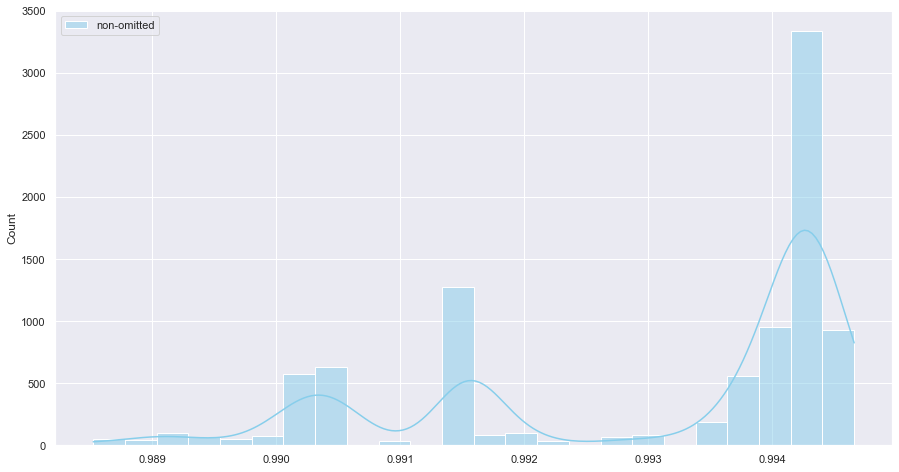

In [91]:
def plotHistorgam(confidenceScores):
    '''
    Plots histogram of confidence scores 

            Parameters:
                    probas (numpy array): 2d array of class probabilities

            Returns:
                    confidenceScores (numpy array): confidence scores
    '''
    sns.set(style="darkgrid")
    df = sns.load_dataset("iris")
    plt.figure(figsize = (15,8))

    sns.histplot(data=confidenceScores, color="skyblue", label="non-omitted", kde=True)

    plt.legend() 
    plt.show()

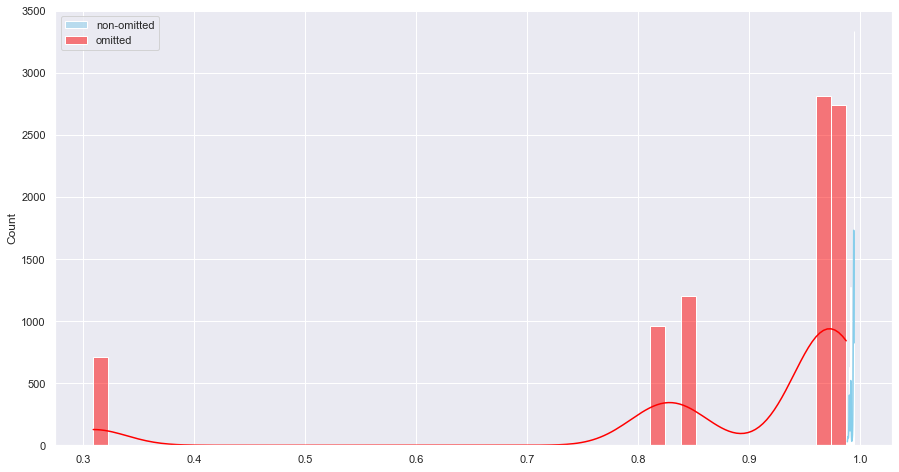

In [93]:
def plotHistograms(confidenceScoresNonOmitted, confidenceScoresOmitted):
    sns.set(style="darkgrid")
    df = sns.load_dataset("iris")
    plt.figure(figsize = (15,8))

    sns.histplot(data=confidenceScoresNonOmitted, color="skyblue", label="non-omitted", kde=True)
    sns.histplot(data=confidenceScoresOmitted, color="red", label="omitted", kde=True)


    plt.legend() 
    plt.show()

In [94]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


#  Drift simulation

In [95]:
len(winningClassCs[:9200]), len(winningClassCsOmitted)

(9200, 8422)

In [96]:
# Split the winning scores of non omitted data into batches of length 20
n=20
#print(winningClassCs[:9200].reshape(460,20))
winningClassCsInBatches = winningClassCs[:9200].reshape(460,20)
#winningClassCsInBatches=np.array([winningClassCs[i:i + n] for i in range(0, len(winningClassCs), n)])
#print(winningClassCsInBatches)
#print(winningClassCsOmitted)

In [97]:
def sudden_quarter():
    #Lists of before and after the changepoint
    befor_cp = winningClassCsInBatches[:230]
    after_cp = winningClassCsInBatches[230:]
    omittedToBeStacked = winningClassCsOmitted[:5*len(after_cp)].reshape(len(after_cp),5)
    x = np.concatenate((after_cp[:,:15],omittedToBeStacked),axis=1)
    x = np.concatenate([befor_cp,x])
    return x
print(sudden_quarter())

[[0.99156095 0.99156095 0.98975858 ... 0.99456825 0.99436126 0.9942455 ]
 [0.9939217  0.99462994 0.99464366 ... 0.99383543 0.99424544 0.9943129 ]
 [0.9939217  0.99411483 0.99426069 ... 0.99430668 0.99273872 0.99377153]
 ...
 [0.99381941 0.99426069 0.9942455  ... 0.98120213 0.98748764 0.98121663]
 [0.99156095 0.99448529 0.99156095 ... 0.96265364 0.96239066 0.30904775]
 [0.99432076 0.99019958 0.99429418 ... 0.84094905 0.98120213 0.84094905]]


In [98]:
def sudden_half():
    #Lists of before and after the changepoint
    befor_cp = winningClassCsInBatches[:230]
    after_cp = winningClassCsInBatches[230:]
    omittedToBeStacked = winningClassCsOmitted[:10*len(after_cp)].reshape(len(after_cp),10)
    x = np.concatenate((after_cp[:,:10],omittedToBeStacked),axis=1)
    x = np.concatenate([befor_cp,x])
    return x
sudden_half()

array([[0.99156095, 0.99156095, 0.98975858, ..., 0.99456825, 0.99436126,
        0.9942455 ],
       [0.9939217 , 0.99462994, 0.99464366, ..., 0.99383543, 0.99424544,
        0.9943129 ],
       [0.9939217 , 0.99411483, 0.99426069, ..., 0.99430668, 0.99273872,
        0.99377153],
       ...,
       [0.99381941, 0.99426069, 0.9942455 , ..., 0.81126551, 0.96265364,
        0.98121663],
       [0.99156095, 0.99448529, 0.99156095, ..., 0.96239066, 0.81126551,
        0.96239066],
       [0.99432076, 0.99019958, 0.99429418, ..., 0.98748764, 0.96265364,
        0.98120213]])

In [99]:
def sudden_full():
    #Lists of before and after the changepoint
    befor_cp = winningClassCsInBatches[:230]
    after_cp = winningClassCsInBatches[230:]
    # Get the confidence scores in baches of length 20
    # Here we use confidence scores until 8420 to avoide the problem \
    #"cannot reshape array of size 8422 into shape (230,20)"
    omittedToBeStacked = winningClassCsOmitted[:8420].reshape(int(len(winningClassCsOmitted[:8420])/20),20)
    x = np.concatenate([befor_cp,omittedToBeStacked])
    return x
sudden_full()

array([[0.99156095, 0.99156095, 0.98975858, ..., 0.99456825, 0.99436126,
        0.9942455 ],
       [0.9939217 , 0.99462994, 0.99464366, ..., 0.99383543, 0.99424544,
        0.9943129 ],
       [0.9939217 , 0.99411483, 0.99426069, ..., 0.99430668, 0.99273872,
        0.99377153],
       ...,
       [0.81126551, 0.81126551, 0.98748764, ..., 0.96237776, 0.98120213,
        0.96239066],
       [0.84094905, 0.98748764, 0.96239066, ..., 0.81126551, 0.30904775,
        0.84094905],
       [0.98120213, 0.98120213, 0.96237776, ..., 0.30904775, 0.96237776,
        0.84094905]])

In [100]:
import rpy2
# import rpy2's package module
import rpy2.robjects.packages as rpackages
from rpy2.robjects import FloatVector
# R vector of strings
from rpy2.robjects.vectors import StrVector

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x000001D32C9C61C8> [RTYPES.NILSXP]

In [101]:
# R package names
packnames = ('cpm')

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [102]:
cpm = rpackages.importr("cpm")

In [103]:
x = sudden_quarter()
x = x.flatten()
vector = x.tolist()
vectorToFloatVector = FloatVector(vector)
a = cpm.detectChangePoint(vectorToFloatVector,"Cramer-von-Mises",ARL0=9000,startup=20)
dataset = pd.DataFrame(np.asarray(a))
dataset

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,0
0,"[0.9915609492986, 0.9915609492986, 0.989758580..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[99999.0, 99999.0, 99999.0, 99999.0, 99999.0, ..."
3,[4615]
4,[4620]
5,[True]


In [104]:
a = cpm.detectChangePoint(vectorToFloatVector,"Student",ARL0=9000,startup=20)
dataset = pd.DataFrame(np.asarray(a))
dataset

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,0
0,"[0.9915609492986, 0.9915609492986, 0.989758580..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[99999.0, 99999.0, 99999.0, 99999.0, 99999.0, ..."
3,[3209]
4,[3217]
5,[True]


In [105]:
x = sudden_half()
x = x.flatten()
vector = x.tolist()
vectorToFloatVector = FloatVector(vector)
a = cpm.detectChangePoint(vectorToFloatVector,"Cramer-von-Mises",ARL0=9000,startup=20)
dataset = pd.DataFrame(np.asarray(a))
dataset

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,0
0,"[0.9915609492986, 0.9915609492986, 0.989758580..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[99999.0, 99999.0, 99999.0, 99999.0, 99999.0, ..."
3,[4610]
4,[4615]
5,[True]


In [106]:
x = sudden_full()
x = x.flatten()
vector = x.tolist()
vectorToFloatVector = FloatVector(vector)
a = cpm.detectChangePoint(vectorToFloatVector,"Cramer-von-Mises",ARL0=9000,startup=20)
dataset = pd.DataFrame(np.asarray(a))
dataset

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,0
0,"[0.9915609492986, 0.9915609492986, 0.989758580..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[99999.0, 99999.0, 99999.0, 99999.0, 99999.0, ..."
3,[4596]
4,[4605]
5,[True]


In [107]:
x = sudden_half()
x = x.flatten()
vector = x.tolist()
vectorToFloatVector = FloatVector(vector)
a = cpm.detectChangePoint(vectorToFloatVector,"Student",ARL0=9000,startup=20)
dataset = pd.DataFrame(np.asarray(a))
dataset

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,0
0,"[0.9915609492986, 0.9915609492986, 0.989758580..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[99999.0, 99999.0, 99999.0, 99999.0, 99999.0, ..."
3,[3209]
4,[3217]
5,[True]


In [108]:
x = sudden_full ()
x = x.flatten()
vector = x.tolist()
vectorToFloatVector = FloatVector(vector)
a = cpm.detectChangePoint(vectorToFloatVector,"Student",ARL0=9000,startup=20)
dataset = pd.DataFrame(np.asarray(a))
dataset

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


,0
0,"[0.9915609492986, 0.9915609492986, 0.989758580..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[99999.0, 99999.0, 99999.0, 99999.0, 99999.0, ..."
3,[3209]
4,[3217]
5,[True]
